In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from mpl_finance import candlestick_ohlc
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib import style

import numpy as np
import pandas as pd
import datetime as dt
import time
import re   #for regular expressions

In [2]:
class Plotter(object):
    def __init__(self,datastream,args):
        self.datastream        = datastream
        self.args              = args 
        self.fig               = plt.figure()
        self.ax1               = self.fig.add_subplot(1,1,1)
        self.plot_func         = None
        self.plot_refresh_rate = args.plot_refresh_rate
        self.candle_width      = args.candle_width
        self._width            = self._convert_candleWidth_to_chartWidth()
        plt.xlabel('Timestamp')
        plt.ylabel('Price')
        
        self._set_plot_function()
    
    def _convert_candleWidth_to_chartWidth(self):
        # determine the frequency of the bars
        num_freq  = re.findall('\d+', self.candle_width)[0]
        timeframe = re.findall('[a-z]+',self.candle_width,re.I)[0].lower()
        #print('TIMEFRAME:',timeframe)
        #Define default number of candles in a day if we assume each candle is 1 second thick
        hours = 24          #bars per day
        mins  = 60          #bars per hour
        secs  = 60          #bars per minute
        num_candles = hours * mins * secs

        #Modify number of candles based on requested bar width
        bar_reduction_rate = 0.85
        if timeframe == 's':
            bar_thickness   = int(num_freq) * bar_reduction_rate
        elif timeframe == 't' or timeframe == 'min':
            bar_thickness   = (int(num_freq) * 60) * bar_reduction_rate
            #print('We are here. Bar_thickness:',bar_thickness)
        new_num_candles = num_candles / bar_thickness

        return 1./new_num_candles

    def clear_canvas(self):
        self.ax1.clear()
        
    def _set_plot_function(self):
        if self.args.plot_mode.lower() == 'tick':
            self.plot_func = self._tick_plotter
        elif self.args.plot_mode.lower() == 'candle':
            self.plot_func = self._candle_plotter
    
    def _tick_plotter(self,i):
        self.ax1.clear()
        for label in self.ax1.xaxis.get_ticklabels():
            label.set_rotation(45)
        self.ax1.plot(self.datastream.timestamps,self.datastream.bids)
        
    def _candle_plotter(self,i):
        '''Function to animate a live chart using matplotlib.animation.FuncAnimation.
        It is defined here for convenience but I will look for a more elegant solution later.'''

        ohlc_df = self.datastream.get_ohlc(self.candle_width)#['bid']
        ohlc_df.set_index('datetime',inplace=True)
        ohlc_df = ohlc_df['bid']
        ohlc_df.reset_index(inplace=True)

        ohlc_df['datetime'] = pd.to_datetime(ohlc_df['datetime'])
        ohlc_df['datetime'] = ohlc_df["datetime"].apply(mdates.date2num)
        self.ax1.clear()
        for label in self.ax1.xaxis.get_ticklabels():
            label.set_rotation(45)
        candlestick_ohlc(self.ax1, ohlc_df.values, width=self._width, colorup='green', colordown='red')
        self.ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

    def plot(self):
        ani = animation.FuncAnimation(self.fig, self.plot_func, interval=self.plot_refresh_rate)      #fig is the canvas we are drawing on. animate is the animation function we defined above. interval is the frecuency (in milliseconds) of refresh for the canvas
        plt.show()
        

        

In [3]:
def ohlc_resample(dataframe, interval):
    i = interval    #do some processing here to make the interval appropriate or to check for correct format
    headers = ['datetime','bid','ask']

    dataframe = dataframe.set_index('datetime')
    #bid_ask_ohlc['datetime'] = pd.to_datetime(bid_ask_ohlc['datetime'])
    dataframe.index = pd.to_datetime(dataframe.index, unit='s')

    bid_ohlc = dataframe['bid'].resample(i).ohlc()
    ask_ohlc = dataframe['ask'].resample(i).ohlc()
    data_bid_ask = pd.concat([bid_ohlc, ask_ohlc], axis=1, keys=['bid','ask'])
    data_bid_ask = data_bid_ask.reset_index()
    return data_bid_ask

class DataStream():
    '''Replacement for OrderBook and should be in a higher level location.'''
    ITER_IDX = 0
    MEANING_DICT = {
        't'  : 'datetime',
        'b'  : 'bid',
        'a'  : 'ask',
        'vb' : 'volume bid',
        'va' : 'volume ask',
        'ob' : 'open interest bid',
        'oa' : 'open interest ask',
        'sym': 'asset symbol (i.e. EUR/USD)'
    }
    def __init__(self):
        self.symbol           = ""
        self.timestamps       = []
        self.bids             = []
        self.asks             = []
        self.volume_bid       = []
        self.volume_ask       = []
        self.openinterest_bid = []
        self.openinterest_ask = []

        self.last_checked     = dt.datetime.utcnow()


    def __len__(self):
        return len(self.timestamps)

    def __iter__(self):
        return self

    def __next__(self):
        i = self.ITER_IDX
        #Check for a stopping condition
        if i >= len(self):
            raise StopIteration()
        else:
            tick = self.get_tick(idx=i)
            self.ITER_IDX += 1
            return tick
        
    def get_dataframe(self,size=-1,empty_data=False,include_cols=['t','b','a']):
        '''size indicates how many rows to include in the dataframe, counting from the last row up.
        empty_data is a flag to see if we should clear all the rows included in the dataframe'''
        if (len(self) < size) or (size < 0):
            start_idx = 0
        else:
            start_idx = len(self) - size
        data = {
            'datetime':self.timestamps[start_idx:],
            'bid'     :self.bids[start_idx:],
            'ask'     :self.asks[start_idx:],
        }
        df = pd.DataFrame(data)
        return df

        
    def get_tick(self,idx=None,tick_format=['t','b','a']):
        '''always returns the latest tick data available.
        format tells the function what information to pack for return. For example,
        the default format is [t,b,a] which tells the program to return timestamp, bid, and ask.
        possible values are:
        t  -> timestamp
        b  -> bid
        a  -> ask
        vb -> volume bid
        va -> volume ask
        ob -> open interest bid
        oa -> open interest ask
        '''
        #Define the correct index to use
        if idx is None:
            i = -1
        else:
            i = idx
        output_tick = []
        for requested_data in tick_format:
            if requested_data.lower()   == 't':
                output_tick.append(self.timestamps[i])
            elif requested_data.lower() == 'b':
                output_tick.append(self.bids[i])
            elif requested_data.lower() == 'a':
                output_tick.append(self.asks[i])
            elif requested_data.lower() == 'vb':
                output_tick.append(self.volume_bid[i])
            elif requested_data.lower() == 'va':
                output_tick.append(self.volume_ask[i])
            elif requested_data.lower() == 'ob':
                output_tick.append(self.open_interest_bid[i])
            elif requested_data.lower() == 'oa':
                output_tick.append(self.open_interest_ask[i])
            elif requested_data.lower() == 'sym':
                output_tick.append(self.symbol)
        return output_tick

        return ohlc_tick

    def _prefill_kargs(self,kargs_dict):
        keys = ['timestamp','bid','ask','volume_bid','volume_ask','openinterest_bid','openinterest_ask']
        for k in keys:
            try:
                kargs_dict[k]
            except KeyError:
                kargs_dict[k] = -1

        return kargs_dict

    def add_tick(self,**kargs):
        kargs = self._prefill_kargs(kargs)
        bid         = kargs['bid']
        ask         = kargs['ask']
        timestamp   = kargs['timestamp']
        openint_bid = kargs['openinterest_bid']
        openint_ask = kargs['openinterest_ask']

        self.timestamps.append(timestamp)
        self.bids.append(bid)
        self.asks.append(ask)
        self.openinterest_bid.append(openint_bid)
        self.openinterest_ask.append(openint_ask)
        #print(f"----->tick added: ({self.timestamps[-1]},{self.bids[-1]},{self.asks[-1]})")
        #try:
        #    printvv("{:<27} {:<10} {:<10}".format(str(self.timestamps[-1]),str(self.bids[-1]),str(self.asks[-1])))
        #except TypeError:
        #    printvv("-----error------")

    def get_ohlc(self,timeframe,num_bars=-1):
        data = self.get_dataframe(size=num_bars)#size=num_bars)
        bid_ask_ohlc = ohlc_resample(data,timeframe)
        return bid_ask_ohlc

    def clear_all_data(self):
        self.symbol = ""
        self.timestamps.clear()
        self.bids.clear()
        self.asks.clear()
        self.volume_bid.clear()
        self.volume_ask.clear()
        self.open_interest_bid.clear()
        self.open_interest_ask.clear()


In [4]:
NUM_TICKS = 10000

def generate_fake_timestamps(num_ticks=10000):
    d = dt.datetime.fromisoformat('2020-02-01 19:12:04.000000')
    delta = dt.timedelta(milliseconds=100)
    timestamps = []
    for i in range(num_ticks):
        d = d + delta
        timestamps.append(d)
    return timestamps
        
def generate_fake_bids_asks(num_ticks):
    base_bid    = 1.1050
    base_ask    = 1.1120
    noise_sigma = 0.01
    mu          = 0
    
    #add gaussian noise to simulate market movements
    bid_noise   = np.random.normal(mu,noise_sigma,size=num_ticks)
    ask_noise   = np.random.normal(mu,noise_sigma,size=num_ticks) + 0.025   #adding a shift up to make sure it is always higher than the bid price
    bids = list(base_bid + bid_noise)
    asks = list(base_ask + ask_noise)
    
    #for i in range(num_ticks):
    #    pass
    
    return bids,asks


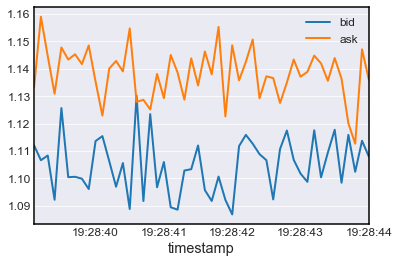

In [5]:
timestamps = generate_fake_timestamps(NUM_TICKS)
bids,asks  = generate_fake_bids_asks(NUM_TICKS)

data = {
    "timestamp":timestamps,
    "bid"      :bids,
    "ask"      :asks,
}

#just making a dataframe to check the data here
df = pd.DataFrame(data=data)
#df.set_index('timestamp')
#df.index = pd.to_datetime(df.index)
df[-50:].plot(x='timestamp',y=['bid','ask'])

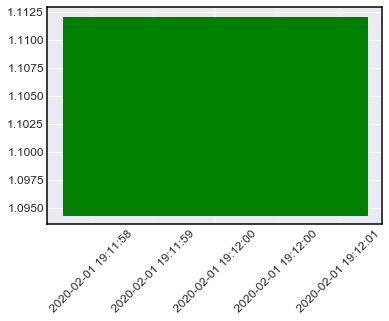

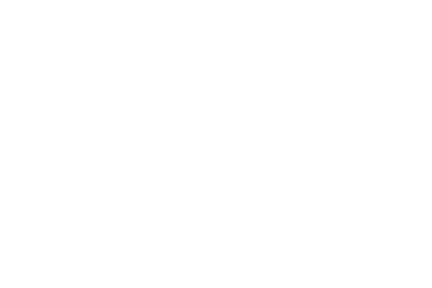

In [6]:
#Below is my attempt at simulating market data streaming.
from types import SimpleNamespace
import threading

datastream = DataStream()
args = SimpleNamespace(
        plot_mode         ='candle',
        plot_refresh_rate = 100,    #in milliseconds
        candle_width      = '5S', 
    )
plotter        = Plotter(datastream,args)


def stream_data(datastream,timestamps,bids,asks):
    first_tick_idx = 0
    for i in range(NUM_TICKS):
        t,b,a = timestamps[i], bids[i], asks[i]
        datastream.add_tick(timestamp=t, bid=b, ask=a)


        candle_delta = dt.timedelta(seconds=5)
        diff = timestamps[-1] - timestamps[first_tick_idx]
        if diff > candle_delta:
            #we have a new candle
            first_tick_idx = i
        time.sleep(0.05)

def plot_data(plotter):
    plotter.plot()
            
streaming_thread = threading.Thread(target=stream_data,args=(datastream,timestamps,bids,asks))
plotting_thread  = threading.Thread(target=plot_data,args=(plotter,))

streaming_thread.start()
plotting_thread.start()